Title: Generate images using KerasCV's StableDiffusion's at unprecedented speeds
Author: [lukewood](https://lukewood.xyz),  [fchollet](https://github.com/fchollet), ... others if relevant
Date created: 2022/24/09
Last modified: 2022/24/09
Description:

## Overview

In this guide, we will show how to generate novel images based on a text prompt using
the KerasCV implementation of [stability.ai's](https://stability.ai/) image to text
model,
[StableDiffusion](https://github.com/CompVis/stable-diffusion).

StableDiffusion is a powerful, open-source text to image generation model.  While there
exist numerous open source implementations that allow you to easily create images from
textual prompts, KerasCV's offers a few distinct advantages.
These include [XLA compilation](https://www.tensorflow.org/xla) and
[mixed precision computation](https://www.tensorflow.org/guide/mixed_precision).

In this guide, we will explore KerasCV's StableDiffusion implementation, show how to use
these powerful performance boosts, and explore the performance benefits
that they offer.

To get started, lets sort out some imports:

In [23]:
import keras_cv
from luketils import visualization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

## Introduction

Unlike most tutorials, where we first explain a topic then show how to implement it,
with text to image generation it is easiest to show instead of tell.

Check out the power of `keras_cv.models.StableDiffusion()`:

In [2]:
stable_diffusion = keras_cv.models.StableDiffusion()

In [36]:
def visualize_prompt(prompt, sd_model=None):
    sd_model = sd_model or stable_diffusion
    visualization.plot_gallery(
        sd_model.text_to_image(prompt, batch_size=3),
        rows=1, cols=3,
        scale=4,
        value_range=(0, 255),
        show=True
    )

25/25 [==============================] - 61s 2s/step


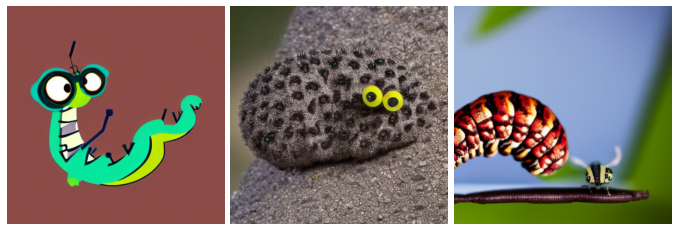

In [18]:
visualize_prompt("a cartoon caterpillar wearing glasses")

Pretty incredible!  

That's not all this model can do.  
Below are an assortment of prompts to spark your imagination as to what this model is capable of:

25/25 [==============================] - 61s 2s/step


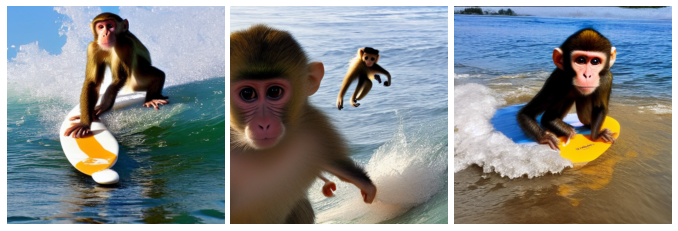

In [15]:
visualize_prompt(
    "The worlds cutest monkey surfing on a "
    "beautiful wave in the sunshine!"
)

25/25 [==============================] - 61s 2s/step


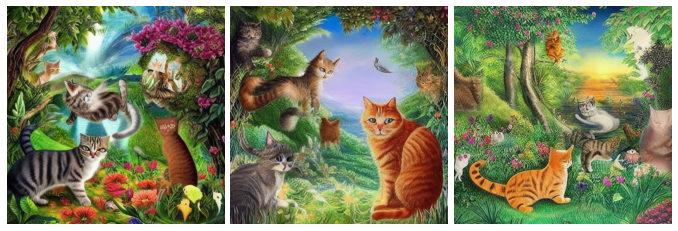

In [19]:
visualize_prompt(
    "Absolutely stunning artwork of the garden of eden, "
    "but filled with cats!"
)

25/25 [==============================] - 61s 2s/step


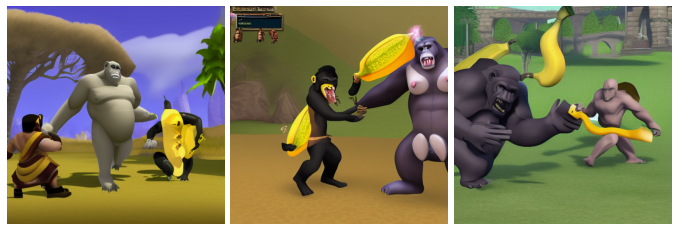

In [20]:
visualize_prompt(
    "Runescape character attacking a gorilla with a HUGE banana"
)

You can even provide an art style!

25/25 [==============================] - 61s 2s/step


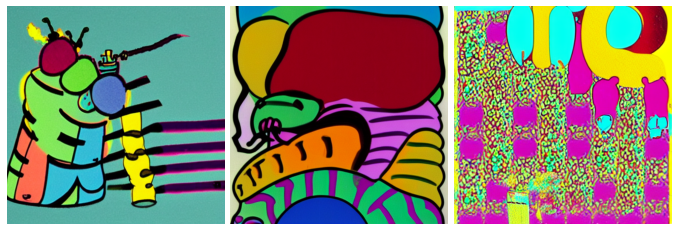

In [21]:
visualize_prompt(
    "a clever caterpillar smoking a rainbow hookah in the style of Andy Warhol"
)

The possibilities are literally endless (or as you will learn later: at least extend to the boundaries of StableDiffusion's latent manifold).

Pretty incredible!  The idea should be self evident at this point.
Now lets take a step back and look at how this algorithm actually works.

## The StableDiffusion Algorithm

## Perks of KerasCV

So, with numerous implementations of StableDiffusion publicly available why shoud you use `keras_cv.models.StableDiffusion()`?

Aside from the easy-to-use API, KerasCV's StableDiffusion model comes with some nice bells and trinkets.  These extra features include but are not limited to:

- out of the box support for XLA compilation
- support for `mixed_precision`
- ...

When these are combined, the KerasCV StableDiffusion model runs orders of magnitude faster than naive implementations.  This section shows how to enable all of these features, and the resulting performance gain yielded from using them.

**Note: The difference between the performance benefits from each optimization vary drastically between hardware**


### XLA Compilation

TensorFlow comes with the [XLA: Accelerated Linear Algebra](https://www.tensorflow.org/xla) compiler built in.
`keras_cv.models.StableDiffusion` supports a `jit_compile` argument out of the box.  
Setting this argument to `True` enables XLA compilation; resulting in a significant speed-up.

Lets use this below.

In [39]:
import time
class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None

    def __enter__(self):
        self.start_time = time.perf_counter()
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.end_time = time.perf_counter()

    @property
    def result(self):
        if self.start_time is None or self.end_time is None:
            raise RuntimeError(
                "Attempting to use timer before timing context is exited."
            )
        return self.end_time - self.start_time
ez_timer = Timer

In [40]:
xla_stable_diffusion = keras_cv.models.StableDiffusion(jit_compile=True)

ResourceExhaustedError: Exception encountered when calling layer "res_block_78" (type ResBlock).

in user code:

    File "/home/lukewood/workspace/keras-cv/keras_cv/models/generative/stable_diffusion/diffusion_model.py", line 135, in call  *
        x = layer(x)
    File "/home/lukewood/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ResourceExhaustedError: Exception encountered when calling layer "padded_conv2d_408" (type PaddedConv2D).
    
    in user code:
    
        File "/home/lukewood/workspace/keras-cv/keras_cv/models/generative/stable_diffusion/__internal__/layers/padded_conv2d.py", line 26, in call  *
            return self.conv2d(x)
        File "/home/lukewood/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/home/lukewood/.local/lib/python3.9/site-packages/keras/backend.py", line 1920, in random_uniform
            return tf.random.uniform(
    
        ResourceExhaustedError: failed to allocate memory [Op:AddV2]
    
    
    Call arguments received by layer "padded_conv2d_408" (type PaddedConv2D):
      • inputs=tf.Tensor(shape=(None, 8, 8, 2560), dtype=float32)


Call arguments received by layer "res_block_78" (type ResBlock):
  • inputs=['tf.Tensor(shape=(None, 8, 8, 2560), dtype=float32)', 'tf.Tensor(shape=(None, 1280), dtype=float32)']

In [ ]:
with ez_timer() as timer:
    visualize_prompt(
        "A cute water-colored otter in a rainbow whirlpool holding shells",
        sd_model=stable_diffusion
    )
print(f"Without XLA took {timer.result} seconds")

In [ ]:
with ez_timer() as timer:
    visualize_prompt(
        "A cute water-colored otter in a rainbow whirlpool holding shells",
        sd_model=xla_stable_diffusion
    )
print(f"With XLA took {timer.result} seconds")

### Mixed Precision

Mixed precision computation is the process of mixing `float32` and `float16` precision dtypes to take advantage of the fact that `float16` operations are significantly faster on modern accelarators.

While a low-level setting, enabling mixed precision computation in Keras (and therefore for `keras_cv.models.StableDiffusion`) is as simple as calling:

In [30]:
mixed_precision.set_global_policy('mixed_float16')

That's all.  It just works.

In [29]:
stable_diffusion_mixed_precision = keras_cv.models.StableDiffusion(jit_compile=True)
print('Old compute dtype:', stable_diffusion.diffusion_model.compute_dtype)
print('Old variable dtype:', stable_diffusion.diffusion_model.variable_dtype)
print('New compute dtype:', stable_diffusion_mixed_precision.diffusion_model.compute_dtype)
print('New variable dtype:', stable_diffusion_mixed_precision.diffusion_model.variable_dtype)

TypeError: Exception encountered when calling layer "clip_encoder_layer_27" (type CLIPEncoderLayer).

in user code:

    File "/home/lukewood/workspace/keras-cv/keras_cv/models/generative/stable_diffusion/text_encoder.py", line 58, in call  *
        x = self.clip_attn(x)
    File "/home/lukewood/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filekm79o17d.py", line 40, in tf__call
        attn_weights = ag__.ld(attn_weights) + ag__.ld(attention_mask)

    TypeError: Exception encountered when calling layer "clip_attention_27" (type CLIPAttention).
    
    in user code:
    
        File "/home/lukewood/workspace/keras-cv/keras_cv/models/generative/stable_diffusion/text_encoder.py", line 105, in call  *
            attn_weights = attn_weights + attention_mask
    
        TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type float16 of argument 'x'.
    
    
    Call arguments received by layer "clip_attention_27" (type CLIPAttention):
      • inputs=tf.Tensor(shape=(None, 77, 768), dtype=float16)
      • attention_mask=None


Call arguments received by layer "clip_encoder_layer_27" (type CLIPEncoderLayer):
  • inputs=tf.Tensor(shape=(None, 77, 768), dtype=float16)

As you can see, the model constructed above now uses mixed precision computation; leveraging the speed of `float16` for computation, and `float32` to store variables.

In [ ]:

with ez_timer.ez_timer() as timer:
    
print(f"took {timer.result} seconds")

In [8]:
generate_and_show(
    "Absolutely stunning artwork of the garden of eden"
    ", but filled with cats!"
)

25/25 [==============================] - 73s 2s/step


NameError: name 'luketils' is not defined

  0   1: 100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.47s/it]


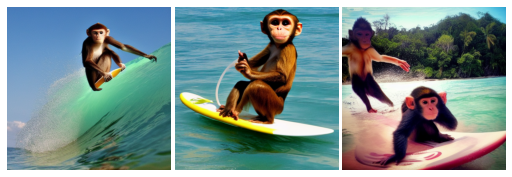

In [41]:
generate_and_show(
    "The worlds cutest monkey surfing on a "
    "beautiful wave in the sunshine!"
)

  0   1: 100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [01:06<00:00,  2.66s/it]


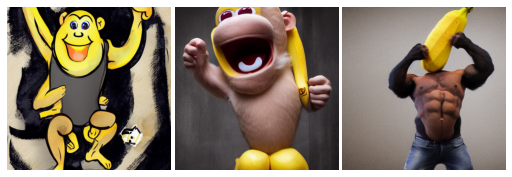

In [40]:
generate_and_show("Super strong monkey lifting sa massive banana in a tank top")

  0   1: 100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.49s/it]


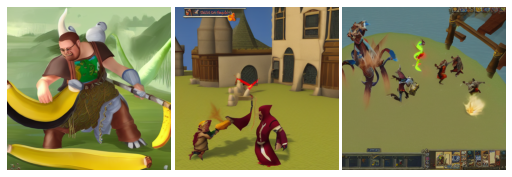

In [48]:
generate_and_show("Runescape character attacking TzTokJad with a HUGE banana")